<a href="https://colab.research.google.com/github/209sontung/Colab/blob/main/Model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Thêm thư viện

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imutils import paths
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf

In [ ]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 3.9MB/s 


In [ ]:
import efficientnet.keras as efn

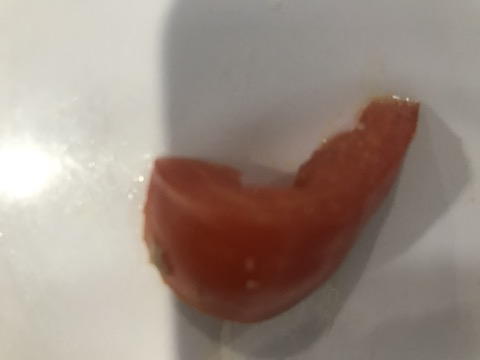

In [3]:
from PIL import Image
image_path = list(paths.list_images('/content/drive/My Drive/Dataset_resized'))
im = Image.open(image_path[1199])
im

# Đổi vị trí ngẫu nhiên các đường dẫn ảnh

In [4]:
random.shuffle(image_path)

# Đường dẫn ảnh sẽ là dataset/tên_loại_rác/tên_ảnh ví dụ dataset-resized/Plastic/plastic209.jpg

In [5]:
labels = [p.split(os.path.sep)[-2] for p in image_path]

# Chuyển tên các loại rác thành số

In [6]:
le = LabelEncoder()
labels = le.fit_transform(labels)

In [7]:
le.classes_

array(['G_M', 'Organic', 'Other', 'Paper', 'Plastic'], dtype='<U7')

# One-hot encoding

In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

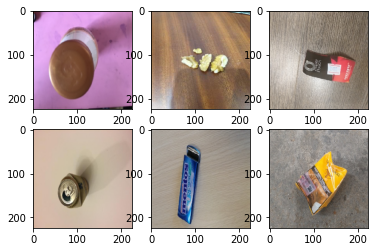

In [9]:
from keras.preprocessing import image
for i, img_path in enumerate(random.sample(image_path, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)

# Load ảnh và resize về đúng kích thước mà MobileNetV2 cần là (224,224)

In [10]:
list_image = []
for (j, imagePath) in enumerate(image_path):
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, 0)
    image = imagenet_utils.preprocess_input(image)
    list_image.append(image)
list_image = np.vstack(list_image)

In [ ]:
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# define data
# save to npy file
savez_compressed('dataset_raw.npz', list_image)

In [ ]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
dict_data = load('list_image.npz')
# extract the first array
data = dict_data['arr_0']
# print the array
print(data)

[[[[ 98.061      93.221     103.32     ]
   [ 98.061      93.221     103.32     ]
   [ 98.061      93.221     103.32     ]
   ...
   [ 63.060997   68.221      78.32     ]
   [ 63.060997   68.221      78.32     ]
   [ 63.060997   68.221      78.32     ]]

  [[ 98.061      93.221     103.32     ]
   [ 98.061      93.221     103.32     ]
   [ 98.061      93.221     103.32     ]
   ...
   [ 63.060997   68.221      78.32     ]
   [ 63.060997   68.221      78.32     ]
   [ 63.060997   68.221      78.32     ]]

  [[ 98.061      93.221     103.32     ]
   [ 98.061      93.221     103.32     ]
   [ 98.061      93.221     103.32     ]
   ...
   [ 63.060997   68.221      78.32     ]
   [ 63.060997   68.221      78.32     ]
   [ 63.060997   68.221      78.32     ]]

  ...

  [[ 94.061      97.221     107.32     ]
   [ 94.061      97.221     107.32     ]
   [ 94.061      97.221     107.32     ]
   ...
   [ 72.061      70.221      77.32     ]
   [ 72.061      70.221      77.32     ]
   [ 72.061     

# Load model MobileNetV2, include_top=False để bỏ phần Fully connected layer

In [11]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


# Freeze MobileNetV2 model

In [12]:
base_model.trainable = False

# Xây dựng model 

In [13]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Chia training set, test set tỉ lệ 80-20

In [14]:
X_train, X_test, y_train, y_test = train_test_split(list_image, labels, 
        test_size=0.2, random_state=42)

In [15]:
len(list_image)

2687

# Augmentation cho training data

In [16]:
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# Augementation cho test data

In [17]:
aug_test= ImageDataGenerator(rescale=1./255)

# Train lần đầu với các Freeze layer

In [18]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6), #Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
batch_size = 32
epochs = 30
steps_per_epoch = len(X_train)//32
validation_steps = len(X_test)//32

history = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=(aug_test.flow(X_test, y_test, batch_size=32)), 
                              validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
67/67 [==============================] - 53s 276ms/step - loss: 1.8602 - accuracy: 0.4572 - val_loss: 0.9340 - val_accuracy: 0.6250
Epoch 2/30
67/67 [==============================] - 20s 291ms/step - loss: 0.8655 - accuracy: 0.6628 - val_loss: 0.8871 - val_accuracy: 0.6406
Epoch 3/30
67/67 [==============================] - 20s 289ms/step - loss: 0.7009 - accuracy: 0.7266 - val_loss: 0.7979 - val_accuracy: 0.6797
Epoch 4/30
67/67 [==============================] - 20s 289ms/step - loss: 0.6260 - accuracy: 0.7537 - val_loss: 0.8855 - val_accuracy: 0.6504
Epoch 5/30
67/67 [==============================] - 20s 289ms/step - loss: 0.5252 - accuracy: 0.8024 - val_loss: 0.9459 - val_accuracy: 0.6836
Epoch 6/30
67/67 [==============================] - 20s 291ms/step - loss: 0.4792 - accuracy: 0.8234 - val_loss: 0.9511 - val_accuracy: 0.6621
Epoch 7/30
67/67 [==============================] - 20s 290ms/step - loss: 0.4178 - accuracy: 0.8434 - val_loss: 1.0130 - val_accuracy: 0.6602

# Fine-tuning

In [20]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [22]:
history_fine = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs, 
                              workers=4,
                              validation_data=(aug_test.flow(X_test, y_test, batch_size=32)), 
                              validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
67/67 [==============================] - 24s 300ms/step - loss: 0.8230 - accuracy: 0.7345 - val_loss: 0.9760 - val_accuracy: 0.7266
Epoch 2/30
67/67 [==============================] - 21s 297ms/step - loss: 0.5394 - accuracy: 0.8132 - val_loss: 0.9919 - val_accuracy: 0.7324
Epoch 3/30
67/67 [==============================] - 21s 296ms/step - loss: 0.4507 - accuracy: 0.8352 - val_loss: 0.9869 - val_accuracy: 0.7266
Epoch 4/30
67/67 [==============================] - 21s 298ms/step - loss: 0.3954 - accuracy: 0.8632 - val_loss: 0.9917 - val_accuracy: 0.7188
Epoch 5/30
67/67 [==============================] - 21s 294ms/step - loss: 0.2992 - accuracy: 0.8981 - val_loss: 0.9925 - val_accuracy: 0.7324
Epoch 6/30
67/67 [==============================] - 21s 294ms/step - loss: 0.3227 - accuracy: 0.8795 - val_loss: 1.0028 - val_accuracy: 0.7520
Epoch 7/30
67/67 [==============================] - 21s 295ms/step - loss: 0.2801 - accuracy: 0.8938 - val_loss: 0.9432 - val_accuracy: 0.7441

# Vẽ biểu đồ

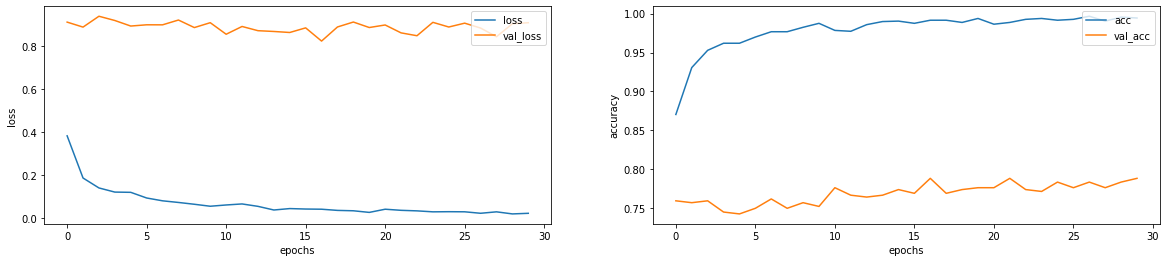

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history_fine.history['loss'], label='loss')
axs[0].plot(history_fine.history['val_loss'], label='val_loss')

axs[1].plot(history_fine.history['accuracy'], label='acc')
axs[1].plot(history_fine.history['val_accuracy'], label='val_acc')

axs.flat[0].set(xlabel='epochs', ylabel='loss')
axs.flat[1].set(xlabel='epochs', ylabel='accuracy')

for i,ax in enumerate(axs):
  axs[i].legend(loc="upper right")
plt.show()

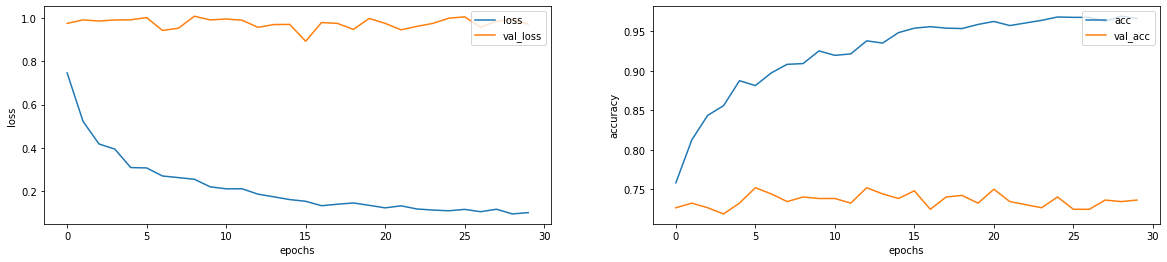

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

axs[0].plot(history_fine.history['loss'], label='loss')
axs[0].plot(history_fine.history['val_loss'], label='val_loss')

axs[1].plot(history_fine.history['accuracy'], label='acc')
axs[1].plot(history_fine.history['val_accuracy'], label='val_acc')

axs.flat[0].set(xlabel='epochs', ylabel='loss')
axs.flat[1].set(xlabel='epochs', ylabel='accuracy')

for i,ax in enumerate(axs):
  axs[i].legend(loc="upper right")
plt.show()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 256)         2949376   
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 256)         0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1285      
Total params: 5,208,645
Trainable params: 4,812,101
Non-trainable params: 396,544
_________________________________________________________________


In [25]:
le.classes_

array(['G_M', 'Organic', 'Other', 'Paper', 'Plastic'], dtype='<U7')

Other
Run time:  0:00:00.056991
Confidence:  0.965


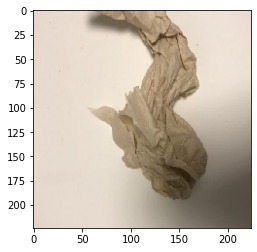

In [30]:
import datetime
begin_time = datetime.datetime.now()
img_path = "/content/drive/My Drive/ColabNotebooks/TestTrash/trash/trash13.jpg"

img = load_img(img_path, target_size=(224, 224))
img = img_to_array(img, dtype=np.uint8)
plt.imshow(img)
img = imagenet_utils.preprocess_input(img)
img = np.expand_dims(img/255, 0)
p = model.predict(img)
confidences = max(np.squeeze(p))
conf = round(confidences, 3)
predicted_class = le.classes_[np.argmax(p[0], axis=-1)]
print(predicted_class)
print('Run time: ', datetime.datetime.now() - begin_time)
print('Confidence: ', conf )

In [ ]:
model.save("my_model.h5")